<a href="https://colab.research.google.com/github/fkhafizov/w2v_intro/blob/main/w2v_sch131_2021_10_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# w2v_sch131_2021.10.15.ipynb
# 
# w2v_skpgr_noW1_v2ru_20211004 2021.10.04 Russian v2
# w2v_skpgr_noW1_v6.ipynb2021.08.19
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import time


import sys
print('sys.executable = ',sys.executable)
print('sys.version = ', sys.version)
print('sys.version_info = ', sys.version_info)

print('np.__version__ = ',np.__version__)
print('pd.__version__ = ',pd.__version__)
print('torch.__version__ = ',torch.__version__)
print('matplotlib.__version__ = ',matplotlib.__version__)

# '''
# np.__version__ =  1.18.5
# pd.__version__ =  1.0.5
# torch.__version__ =  1.4.0
# matplotlib.__version__ =  3.2.2
#'''

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sys.executable =  /usr/bin/python3
sys.version =  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
sys.version_info =  sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)
np.__version__ =  1.19.5
pd.__version__ =  1.1.5
torch.__version__ =  1.9.0+cu111
matplotlib.__version__ =  3.2.2


# Introduction to Skip-gram

### Skip-gram Algorithm was introduced in [1] and improved in [2]
* [1] [Mikolov et al, 2013.09](https://arxiv.org/pdf/1301.3781.pdf)
* [2] [Mikolov et al, 2013.10](https://arxiv.org/pdf/1310.4546.pdf)

Formulation of optimization problem for the **baseline algorithm** described in section 2 of [2] is as follows.

### Notation 

Given text with vocabulary, $V$, of size $|V|$, window size $c$ ($c=2$ in our example below), and embedding space dimention (2 in our example) we construct a set  training word pairs $(w_{center}, w_{context})$.

$idx(w) := $  index of word $w$ in the $V$.

$W_0$ is a $|V| \times 2$ matrix. Rows are embeddings of center words.

$W_1$ is a $2 \times |V|$ matrix. Columns are embeddings of context words.

$x:=W_0[idx(w_{center}),:]$ is a 2D row-vector = embedding of $w_{center}$ (also denoted as $w_x$).



$y':=W_1[:,idx(w_{context})]$ is a 2D column-vector =  embedding of $w_{context}=w_y$.


$x\cdot W_1$ is a row-vector of length $|V|$. Each entry is a dot product $x\cdot y_v'$ for some $y_v'$.






### Skip-Gram Model

$$P(w_{context} | w_{center}) = P(w_y|w_x) := \frac{\exp(x\cdot y')}{\sum_{v=1}^{|V|}\exp(x\cdot y'_v)}
$$

$$
U(W_0, W_1)  := \frac{1}{T} \sum_{t=1}^T \sum_{-c\le j \le c, j\ne 0} \log P(y_{t+j}|x_t) 
$$

Given a sequence of training words $w_1, w_2, w_3, \dots , w_T$ , the objective of the Skip-gram model is to maximize $U(W_0, W_1)$:
$$\max_{W_0, W_1} U(W_0, W_1)  $$

---

### Note: 

Often the following question is being asked: is it necessary to have two weight matrices $W_0$ and $W_1$? It turns out, that  one matrix is sufficient as we illustrate in our example below. Therefore, the code below is an implementation of 

### Simplified Skip-Gram Model (with only one weight matrix)

Let $\displaystyle  W_1:=W_0'$, $\quad T=$  the size of the set of training word pairs,  and 

$$U=U(W_0)  := \frac{1}{T} \sum_{t=1}^T \log P(y_t|x_t)$$

Then the objective is  to maximize $U(W_0)$.






# Auxilary Functions

In [2]:
def remove_stop_words(corpus):
    stop_words = ['in','very','are','the','to','of','is', 'a', 'and',\
                  'on','will', 'be', 'и', 'он', 'этот', 'она', 'очень', 'в', 'она']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    return results



def plot_words(W, vocab, ttl, wcolor):
    # plot words according to their embedding
    x1 = W[:,0]
    x2 = W[:,1]
    x_axis_min, x_axis_max = np.min(x1)-get_padding(x1), np.max(x1)+get_padding(x1)
    y_axis_min, y_axis_max = np.min(x2)-get_padding(x2), np.max(x2)+get_padding(x2)

    fig, ax = plt.subplots()
    figsz=4
    plt.rcParams["figure.figsize"] = (figsz,figsz)

    plt.scatter(x1, x2, c='orange', s=500, alpha=1.0)
    for ix, word, x1i, x2i in zip(range(len(wcolor)), vocab, x1, x2):
        ax.annotate(word, (x1i,x2i ), fontsize=18, color=wcolor[ix])

    # Plot Center
    plt.scatter([0], [0], c='g', marker='+', s=500, alpha=0.9)     
    plt.grid()
    plt.xlim(x_axis_min,x_axis_max)
    plt.ylim(y_axis_min,y_axis_max)
    
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    
    plt.title(ttl, fontsize=18)

    #     fig.savefig(fname=figfn, formatstr='png')
    plt.show()

def get_padding(x):
    return 2*(np.max(x)-np.min(x))/10

# Prepare Text

In [3]:
text = "Fish swim in deep water. Ocean is very deep. Fish swim in darkness. \
          Birds are high in the sky. Birds fly very high. On a sunny day the sky is full of light."

text = "Рыба плавает глубоко в воде. Дно океана очень глубоко. Рыба плавает в темноте. \
             Птицы улетели в небо. Птицы летают очень высоко. В солнечный день небо чистое."

# text = "Fish and water. Birds and sky."

# Text should have even number of sentences. This will help with illustration.
# Words in the 1st half will be 'red'.
# Words in the 2nd half of sentences must be 'cyan'.
print('TEXT = ', text)

corpus=[s.lower().strip() for s in text.split('.')][:-1]
corpus = remove_stop_words(corpus)
print('\nCLEAN CORPUS = ',corpus)
sentences = [s.split(' ') for s in corpus]
print('\nSENTENCES = ',sentences)

# GET VOCAB
vocab=[]
for ss in sentences:
  # print(ss)
  vocab += ss
    
vocab = sorted(set(vocab))
print('\nVOCABULARY = ', vocab)
print(len(vocab))



# DICs mapping each word to a number and vice-versa
word2idx = {w: idx for (idx, w) in enumerate(vocab)}
idx2word = {idx: w for (idx, w) in enumerate(vocab)}
'''
print('word2idx=', word2idx)
print('idx2word=', idx2word)
'''

# COUNT WORDS
vocab_word_count = np.zeros(len(vocab))
for ss in sentences:
    for word in ss:
        idx = vocab.index(word) 
        vocab_word_count[idx] += 1
# print('vocab_word_count = ',vocab_word_count)


# Create master DF for our data 
vocab_df = pd.DataFrame( columns=['vocab','color'] )

# assign colors
# ASSUME: corpus has even number of sentences. First half must be 'red'.
# Words in the second half of sentences must be 'blue'
ix=0
for i, ss in zip(range(len(sentences)), sentences):
    wordcolor = 'red' if i<len(sentences)/2 else 'blue'
    for w in ss:
        vocab_df.loc[ix]=[w, wordcolor]
        ix+=1
        
total_number_of_words = ix
vocab_df = vocab_df.drop_duplicates().sort_values(by='vocab').reset_index(drop=True)
vocab_df['count']=vocab_word_count
vocab_df['freq'] = vocab_df['count']/total_number_of_words


# initialize dictionary of context words
context_words = {}
for w in vocab:
    context_words[w] = []

WINDOW_SIZE = 2
data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) :\
                                 min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
                context_words[word].append(neighbor)

df_context_words = pd.DataFrame({'vocab': list(context_words.keys()),   \
                                 'c_words': list(context_words.values())})

df_context_words['num_c_words_pairs'] = [ len(wrds) for wrds in list(context_words.values()) ]
df_context_words['set_c_words'] = [ set(wrds) for wrds in list(context_words.values()) ]
df_context_words['num_c_words'] = [ len(set(wrds)) for wrds in list(context_words.values()) ]
vocab_df2 = vocab_df.merge( df_context_words, how='outer',on=['vocab'] )
tr_pairs = pd.DataFrame(data, columns = ['center', 'context'])
print(tr_pairs.head())
print('...')
print(tr_pairs.tail())



TEXT =  Рыба плавает глубоко в воде. Дно океана очень глубоко. Рыба плавает в темноте.              Птицы улетели в небо. Птицы летают очень высоко. В солнечный день небо чистое.

CLEAN CORPUS =  ['рыба плавает глубоко воде', 'дно океана глубоко', 'рыба плавает темноте', 'птицы улетели небо', 'птицы летают высоко', 'солнечный день небо чистое']

SENTENCES =  [['рыба', 'плавает', 'глубоко', 'воде'], ['дно', 'океана', 'глубоко'], ['рыба', 'плавает', 'темноте'], ['птицы', 'улетели', 'небо'], ['птицы', 'летают', 'высоко'], ['солнечный', 'день', 'небо', 'чистое']]

VOCABULARY =  ['воде', 'высоко', 'глубоко', 'день', 'дно', 'летают', 'небо', 'океана', 'плавает', 'птицы', 'рыба', 'солнечный', 'темноте', 'улетели', 'чистое']
15
    center  context
0     рыба  плавает
1     рыба  глубоко
2  плавает     рыба
3  плавает  глубоко
4  плавает     воде
...
    center    context
39    небо  солнечный
40    небо       день
41    небо     чистое
42  чистое       день
43  чистое       небо


In [4]:
# vocab_df2

# Simplified Skip-Gram Model (no W1)

In [5]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time

EMBEDDING_DIMENSION = 2
W0 = Variable(torch.randn(len(vocab), EMBEDDING_DIMENSION).float(), requires_grad=True)
W0_init = torch.clone( W0 )

vocab_df['init_embedding']=[np.round(v,2) for v in  W0_init.cpu().detach().numpy()]
vocab_df[ ['vocab', 'init_embedding' ] ]



,vocab,init_embedding
0,воде,"[1.84, 0.6]"
1,высоко,"[-2.59, -0.75]"
2,глубоко,"[0.42, 1.41]"
3,день,"[0.64, -0.07]"
4,дно,"[0.15, -0.48]"
5,летают,"[-1.24, -0.23]"
6,небо,"[0.1, -1.39]"
7,океана,"[-1.42, -0.34]"
8,плавает,"[0.13, 1.92]"
9,птицы,"[0.77, -0.69]"


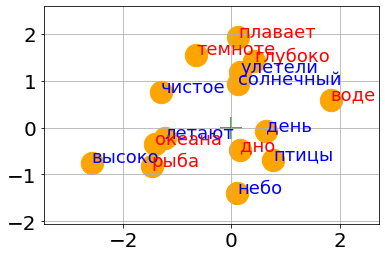

In [6]:
%matplotlib inline
# %matplotlib notebook

# plot_words(W0_init.cpu().detach().numpy(), vocab, ttl='Initial embedding', wcolor=vocab_df.color)
plot_words(W0_init.cpu().detach().numpy(), vocab, ttl='', wcolor=vocab_df.color)


# Main Loop


In [7]:
U_array = []

In [8]:
EPOCHS = 1000
LEARNING_RATE = 0.001
pair_ix = 24  # index of contect pair for prints
sttime = time.time()

# PyTorch Training
for epoch in range(EPOCHS):
    U = 0
    for i in range(len(tr_pairs)):
        
        w_center     = tr_pairs.center[i]
        w_context    = tr_pairs.context[i]
        
        w_center_ix  = word2idx[w_center]
        w_context_ix = word2idx[w_context]
        
        w_center_embed = W0[word2idx[tr_pairs.center[i]],:]        
        dot_products = torch.matmul( w_center_embed, torch.transpose(W0, 0, 1) )      
        log_softmax = F.log_softmax(dot_products, dim=0)
        
        ix = torch.tensor([w_context_ix])
        U_increment = torch.mul( F.nll_loss( log_softmax.view(1,-1), ix ), torch.tensor([-1.0]) )
        U += U_increment.item()       
        
        if (epoch % 300 == 0) & \
           (w_center  == tr_pairs.center[pair_ix]) & \
           (w_context == tr_pairs.context[pair_ix]):
            U_incr_val = round(U_increment.cpu().detach().numpy()[0],3)
            if epoch == 0:
                print(f'    w_center={w_center}, w_center_ix={w_center_ix}', 
                      f'  w_context={w_context}, w_context_ix={w_context_ix} ')    
            print( f'  * epoch={epoch},  i={i}, U=',np.round(U,4),
                 '   U_increment=',  U_incr_val  )
        
        U_increment.backward()
        W0.data += LEARNING_RATE * W0.grad.data
        W0.grad.data.zero_()
        
    U_array.append(U)

endtime = time.time()
ttl = f'Epochs={len(U_array)}, LR={LEARNING_RATE}, time={int(endtime-sttime)} sec'

print('Finished training with: U=',np.round(U,4),'\n', ttl)

    w_center=улетели, w_center_ix=13   w_context=птицы, w_context_ix=9 
  * epoch=0,  i=24, U= -99.9474    U_increment= -4.282
  * epoch=300,  i=24, U= -53.1782    U_increment= -2.421
  * epoch=600,  i=24, U= -48.944    U_increment= -1.86
  * epoch=900,  i=24, U= -47.391    U_increment= -1.605
Finished training with: U= -78.3351 
 Epochs=1000, LR=0.001, time=12 sec


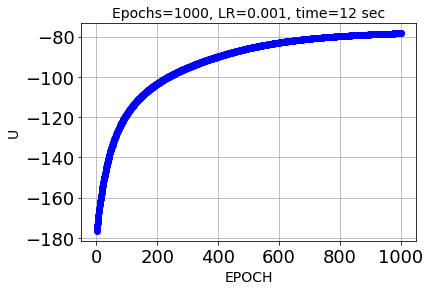

In [9]:
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (6,6)

epochs = range(1, len(U_array)+1)
plt.plot(epochs, U_array, 'bo')

plt.title(ttl, fontsize=14)
plt.xlabel('EPOCH', fontsize=14)
plt.ylabel('U', fontsize=14)
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

vocab_df['embedding']=[np.round(v,2) for v in  W0.cpu().detach().numpy()]
# vocab_df

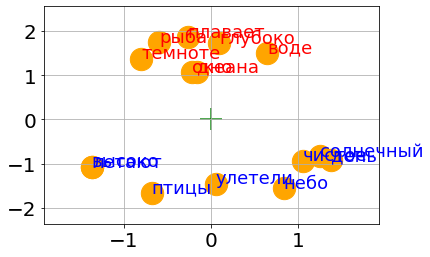

In [10]:
%matplotlib inline
# %matplotlib notebook
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (6,6)

# plot_words(W0.cpu().detach().numpy(), vocab, ttl=ttl, wcolor=vocab_df.color)
plot_words(W0.cpu().detach().numpy(), vocab, ttl='', wcolor=vocab_df.color)


In [11]:
W0

tensor([[ 0.6415,  1.5116],
        [-1.3659, -1.0630],
        [ 0.0920,  1.7341],
        [ 1.3703, -0.9203],
        [-0.1619,  1.0735],
        [-1.3605, -1.0669],
        [ 0.8319, -1.5473],
        [-0.2152,  1.0688],
        [-0.2677,  1.8544],
        [-0.6782, -1.6558],
        [-0.5891,  1.7402],
        [ 1.2493, -0.8236],
        [-0.7991,  1.3753],
        [ 0.0569, -1.4499],
        [ 1.0501, -0.9285]], requires_grad=True)

# Code for SLIDE "TRAINING"

In [13]:
# type(W0)  tensor([0.1529, 1.2841], grad_fn=<SelectBackward>)
# M0= W0.cpu().detach().numpy()


M0 = np.array([[ 1.9, -0.7],
       [-1.6, -1. ],
       [-1.1, -0. ],
       [-0.4,  0.2],
       [-1.2, -1. ],
       [-0.9, -0.2],
       [-1.1, -0.4],
       [-1.5,  1.4],
       [-0.1, -1. ],
       [-0.5, -1.3],
       [-0.8,  0.4],
       [ 0.5, -1.1],
       [-0.4,  0.7],
       [ 0.1, -0.2],
       [ 0.7, -0.8]])
M0

array([[ 1.9, -0.7],
       [-1.6, -1. ],
       [-1.1, -0. ],
       [-0.4,  0.2],
       [-1.2, -1. ],
       [-0.9, -0.2],
       [-1.1, -0.4],
       [-1.5,  1.4],
       [-0.1, -1. ],
       [-0.5, -1.3],
       [-0.8,  0.4],
       [ 0.5, -1.1],
       [-0.4,  0.7],
       [ 0.1, -0.2],
       [ 0.7, -0.8]])

In [14]:
M1 = np.array([[ 0.2, -1.4, -0.8,  1.3, -1.5, -1.4,  0.6, -1.5,  0.4, -0.9,  0.3,  1.1,  0.5, -0.3,  1.1],
       [ 1.3, -1.2,  1.6, -1.4,  0.9, -1.2, -1.9,  0.9,  1.8, -1.8,  1.7, -1.3,  1.4, -1.7, -1.3]])

import sys
np.set_printoptions(suppress=True,linewidth=sys.maxsize,threshold=sys.maxsize)

# from shutil import get_terminal_size
# pd.set_option('display.width', get_terminal_size()[0])

# M1= np.round(W0n.T,1)
print(M1)

[[ 0.2 -1.4 -0.8  1.3 -1.5 -1.4  0.6 -1.5  0.4 -0.9  0.3  1.1  0.5 -0.3  1.1]
 [ 1.3 -1.2  1.6 -1.4  0.9 -1.2 -1.9  0.9  1.8 -1.8  1.7 -1.3  1.4 -1.7 -1.3]]


In [15]:
x=M0[8,:]
x

array([-0.1, -1. ])

In [16]:
np.dot(x,M1)

array([-1.32,  1.34, -1.52,  1.27, -0.75,  1.34,  1.84, -0.75, -1.84,  1.89, -1.73,  1.19, -1.45,  1.73,  1.19])

# Slide "OBJECTIVE FUNCTION"

### Skip-Gram Model

$$P(w_{context} | w_{center}) = P(w_y|w_x) := \frac{\exp(x\cdot y')}{\sum_{v=1}^{|V|}\exp(x\cdot y'_v)}
$$

$$
U(W_0, W_1)  := \frac{1}{T} \sum_{t=1}^T \sum_{-c\le j \le c, j\ne 0} \log P(y_{t+j}|x_t) 
$$


Алгоритм Skip-Gram пытается максимизировать целевую функцию $U(W_0, W_1)$, которая зависит от векторного вложения наших слов $w_1, w_2, w_3, \dots , w_T$ выбранных из текста.
$$\max_{W_0, W_1} U(W_0, W_1)  $$

Given a sequence of training words $w_1, w_2, w_3, \dots , w_T$ , the objective of the Skip-gram model is to maximize $U(W_0, W_1)$:
$$\max_{W_0, W_1} U(W_0, W_1)  $$

---

# Вектор, скалярное произведение, матричное умножение

$\vec{f}\cdot\vec{g} := |\vec{f}|\, |\vec{g}|\, \cos\theta$

$\vec{f}\cdot\vec{g} = (f_1,f_2)\cdot(g_1,g_2) = f_1g_1 + f_2g_2$

$\displaystyle \vec{x}\,  \vec{y} =$

# Вектор, скалярное произведение, матричное умножение

$\vec{a}\cdot\vec{b} \ := \ |\vec{a}|\, |\vec{b}|\, \cos\theta$

$\vec{a}\cdot\vec{b} \  =  \
(a_1,a_2)\cdot(b_1,b_2) \  =  \
a_1b_1 + a_2b_2$

$
\begin{bmatrix}
6 & 9
\end{bmatrix}
\begin{bmatrix}
-1 \\
1 
\end{bmatrix} 
\ \ = \ \
(6,9)\cdot (-1,1) 
\ \ = \ \
6\,(-1) + 9\,(1) 
\ \ = \ \
3 
$


$\begin{bmatrix}
6 & 9
\end{bmatrix}
\begin{bmatrix}
-1 & 1 & -2 \\
1 & 0 & 1
\end{bmatrix} \ = \
\begin{bmatrix}
3 & 6 & -3
\end{bmatrix} 
$


$\displaystyle  f(2) 
\ + \ 
\epsilon f'(2) \ > \ f(2) \qquad\qquad\text{if } f'(2)>0 $

$\displaystyle f(\vec{a}) 
\ + \ 
\epsilon  \Big( \nabla f (\vec{a})\Big) 
\ > \ 
f(\vec{a}) $

$\displaystyle \nabla f(a_1, a_2) := 
\Big( \frac{\partial f}{\partial a_1}
\ , \
\frac{\partial f}{\partial a_2} \Big). \qquad$




Пример: для  $f(\vec{a}) = f(a_1, a_2) = \sin(a_1) + 5 a_2, \quad$
$\displaystyle \nabla f(a_1, a_2)= \Big( \cos( a_1) \ , \ 5 \Big)$.

Если $(a_1,a_2) = (\pi/2, 1) $, то вектор $\nabla f(a_1, a_2) = (0,5)$ указывает направление наибольшего возрастания функции $f$ из точки 
$(\pi/2, 1, 6)$.





# Matrix Multiplication


$\displaystyle \qquad x\, W_0 =
\begin{pmatrix}
-1 & 1 & 2
\end{pmatrix}
\begin{pmatrix}
1 & 2 \\
3 & 1 \\
2 & 5
\end{pmatrix}
=
\begin{pmatrix}
6 & 9
\end{pmatrix}
$

$\displaystyle y' = x\, W_0 \, W_1 =
\begin{pmatrix}
6 & 9
\end{pmatrix}
\begin{pmatrix}
-1 & 1 & -2 \\
1 & 0 & 1
\end{pmatrix} =
\begin{pmatrix}
3 & 6 & -3
\end{pmatrix} 
$

# Dot Product 

$(a,b) \cdot (n,k) = an + bk$

$(3, 5) \cdot (-2,1) = 3(-2) + 5(1) = -6+5 = -1$


# Cosine Similarity
How similar (close) are vectors $y=(0.9, \ 2.1, \ -1.1)$ and 
$y'=(3, \ 6, \ -3) = 3(1, \ 2, \ -1)$?

Cosine Similarity $(y,y') = \displaystyle
\cos\alpha = \frac{ y\cdot y' }{ |y| |y'| } = 0.998
$


Cosine Similarity $((1,0,0), \ (0,1,0)) \ = \cos(\pi/2) = 0$


# Utility Function

$$
p(y | x) = \frac{\exp( y'\cdot x)}
{  \sum_{v=1}^{|V|} \exp(y_v'\cdot x) }
$$

Here $y_v$ and $y_v'$ are the input and output vector representations of word $w_v$ for all words in the vocabulary $V$.

The utility function that we want to maximize is the average log probability
$$
\frac{1}{T} \sum_{t=1}^T 
\sum_{ -c\le j\le c, j\ne 0} \log p(y_{t+j} | x_t)
$$

